In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from graph.graph_pg_extra import generate_graph_and_matrices
import numpy as np
import inspect 
import os
import copy as cp 
import matplotlib
from matplotlib.font_manager import FontProperties
from tqdm import tqdm
from utilities.asy_dagp_utils import update_estimates_dagp, update_variables_dagp, broadcast_dagp, save_vars_dagp

from Problems.synthetic_cosh import synthetic
from analysis.analysis import error
from graph.graph import Random
from utilities import utilities as ut
from Optimizers import DOPTIMIZER as dopt
%matplotlib inline

In [3]:
#### define necessary functions that buid the delay factor
def base_function(m, k, z_p):
    exponent = np.abs(k - m)
    sign = 1 if (k - m) >= 0 else -1
    return (z_p ** exponent) * sign

def term_1(m, K, z_p):
    return 2*sum([abs(base_function(m, k, z_p)) for k in K])

def term_3_inner_function(m, k1, z_p, other_ks, c):
    """
    - m (int): Parameter for the base function.
    - k1 (float): The k value for the primary base function.
    - z_p (float): The common z_p value used in the base function.
    - other_ks (list[float]): A list of k values for the other base functions.
    - c (float): A scaling constant applied to the sum of the other base functions.
    """
    first_term = base_function(m, k1, z_p)
    sum_of_terms = np.float64(c) * sum([base_function(m, k, z_p) for k in other_ks])
    return abs(first_term - sum_of_terms)
 
def term_3(m, k1_range, z_p, other_ks_list, c_list):    
    """
    - m (int): Parameter for the base function.
    - k1_values (list[float]): A list of k1 values.
    - z_p (float): The common z_p value used in the base function.
    - other_ks_list (list[list[float]]): A list where each element is a list of k values for the other base functions.
    - c_list (list[float]): A list of scaling constants for each group of other base functions.
    """    
    return sum([term_3_inner_function(m, k1, z_p, other_ks, c) for k1, other_ks, c in zip(k1_range,other_ks_list,c_list)])

def base_function2(m, k, z_p):
    exponent = np.abs(k-1 - m)
    sign = 1 if (k-1 - m) >= 0 else -1
    return (z_p ** exponent) * sign

def term_2_inner_function(m, k1, z_p, other_ks, c):
    first_term = base_function2(m, k1, z_p)
    sum_of_terms = np.float64(c) * sum([base_function2(m, k, z_p) for k in other_ks])
    return abs(first_term - sum_of_terms)
 
def term_2(m, k1_range, z_p, other_ks_list, c_list):    
    return sum([term_2_inner_function(m, k1, z_p, other_ks, c) for k1, other_ks, c in zip(k1_range,other_ks_list,c_list)])

In [4]:
def compute_delay_matrix(seed, num_nodes, max_iter, delay_type):
    np.random.seed(seed)
    if delay_type == 'uniform:1-100':
        Delay_mat = np.random.uniform(1, 100, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-50':
        Delay_mat = np.random.uniform(1, 50, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-60':
        Delay_mat = np.random.uniform(1, 60, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform_1-40_with_ideal':
        Delay_mat = np.random.uniform(1, 40, size=(num_nodes,num_nodes,max_iter+2))
        flat_matrix = Delay_mat.flatten()
        num_zeros = int(flat_matrix.size // 2)
        random_indices = np.random.choice(flat_matrix.size, num_zeros, replace=False)
        flat_matrix[random_indices] = 0
        Delay_mat = flat_matrix.reshape(Delay_mat.shape)        
    elif delay_type == 'uniform_1-40_with_loss':
        Delay_mat = np.random.uniform(1, 40, size=(num_nodes,num_nodes,max_iter+2))
        flat_matrix = Delay_mat.flatten()
        num_zeros = flat_matrix.size // 2
        random_indices = np.random.choice(flat_matrix.size, num_zeros, replace=False)
        flat_matrix[random_indices] = 1e7
        Delay_mat = flat_matrix.reshape(Delay_mat.shape)   
    elif delay_type == 'uniform:1-80':
        Delay_mat = np.random.uniform(1, 80, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-1':
        Delay_mat = np.random.uniform(1, 1, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-2':
        Delay_mat = np.random.uniform(1, 2, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-3':
        Delay_mat = np.random.uniform(1, 3, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-4':
        Delay_mat = np.random.uniform(1, 4, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-20':
        Delay_mat = np.random.uniform(1, 20, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-30':
        Delay_mat = np.random.uniform(1, 30, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-40':
        Delay_mat = np.random.uniform(1, 40, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-5':
        Delay_mat = np.random.uniform(1, 5, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-10':
        Delay_mat = np.random.uniform(1, 10, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-500':
        Delay_mat = np.random.uniform(1, 500, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-1000':
        Delay_mat = np.random.uniform(1, 1000, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-50':
        Delay_mat = np.random.uniform(1, 50, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'exp:scale:10':
        Delay_mat = np.random.exponential(10,   size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'no_delay':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'one_node_constant_delay_500':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        Delay_mat[:,0,:] = np.random.uniform(500,500,(num_nodes, max_iter+2))
    elif delay_type == 'all_nodes_constant_delay_100':
        Delay_mat = np.random.uniform(100, 100, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'all_nodes_constant_delay_500':
        Delay_mat = np.random.uniform(500, 500, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'all_nodes_constant_delay_1000':
        Delay_mat = np.random.uniform(1000, 1000, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == '20percent_1_link_delay_10_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2)) 
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(10,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_20_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2)) 
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(20,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_40_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2)) 
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(40,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_80_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(80,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_160_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(160,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_400_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(400,0,(num_nodes,len(rand_iters)))
    elif delay_type == 'normal_150_10':
        Delay_mat = np.random.normal(150,10, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_20':
        Delay_mat = np.random.normal(150,20, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_40':
        Delay_mat = np.random.normal(150,40, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_80':
        Delay_mat = np.random.normal(150,80, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_600_80':
        Delay_mat = np.random.normal(600,80, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_0':
        Delay_mat = np.random.normal(150,0,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_10_1':
        Delay_mat = np.random.normal(10,1,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_10_5':
        Delay_mat = np.random.normal(10,5,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_10_20':
        Delay_mat = np.random.normal(10,20,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    for i in range(max_iter):
        np.fill_diagonal(Delay_mat[:,:,i], 0)
    range_iters = np.arange(max_iter)
    return Delay_mat[:,:,range_iters]

In [5]:
def tau_vu_p_m(Delay_mat, receiver, sender, min_K, max_K, z_p, m_min, m_max):
    delay_iters  = Delay_mat[receiver,sender,:]
    iters_num    = np.arange(len(delay_iters))
    receive_time = np.ceil(delay_iters + iters_num)
    unique_times = np.unique(receive_time)
    indices_dict = {time: np.where(receive_time == time)[0] for time in unique_times}

    ##### The initial iterations can be considered as a warm start. 
    K = np.arange(min_K,max_K,1)
    empty_iters_in_this_interval     = [element for element in K if element not in indices_dict]
    non_empty_iters_in_this_interval = [element for element in K if element in indices_dict]

    Tvu_all       = []
    c_list1       = []
    receive_iters = []
    c_list2       = []

    for k in K:
        if k in empty_iters_in_this_interval:
            Tvu_all.append([])
            c_list1.append(0)
        elif k in non_empty_iters_in_this_interval:
            Tvu_all.append(indices_dict[k])
            c_list1.append(1/len(indices_dict[k]))

        receive_iters.append([receive_time[k]])
        if receive_time[k] in indices_dict:
            c_list2.append(1/len(indices_dict[receive_time[k]]))

    m_discrete_values = np.arange(m_min, m_max, 1)  
    term1 = [term_1(m, empty_iters_in_this_interval, z_p) for m in m_discrete_values]
    term2 = [term_2(m, K, z_p, other_ks_list=Tvu_all , c_list=c_list1) for m in m_discrete_values]
    term3 = [term_3(m, K, z_p, other_ks_list=receive_iters, c_list=c_list2) for m in m_discrete_values]

    tau_vu_p = np.array(term1)+np.array(term2)+np.array(term3)

    return tau_vu_p, m_discrete_values, term1, term2, term3

In [6]:

def plot_sorted(in_list, show=True):
    kappa_sorted = sorted(in_list)
    indexed_list = list(enumerate(in_list))
    sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])
    sorted_indices = [index for index, value in sorted_indexed_list]

    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    var_names = [var_name for var_name, var_val in callers_local_vars if var_val is in_list]

    if show:
        plt.plot(np.arange(len(kappa_sorted)), kappa_sorted, marker='o') 
        ax = plt.gca()
        new_tick_positions = range(len(kappa_sorted))
        ax.set_xticks(new_tick_positions)
        ax.set_xticklabels(sorted_indices) 

        plt.title(f'{var_names}')
    return sorted_indices

def compute_kappa_and_terms_max(delay_profiles, min_K, z_p, m_min, m_max, folder='check_theorem_figure', show=True):
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
    plt.rcParams['pdf.fonttype'] = 42
    font = FontProperties()
    font.set_size(17)
    linewidth = 2

    kappa_list = []
    term1_list = []
    term2_list = []
    term3_list = []
    for my_delay in delay_profiles:
        max_K = len(my_delay)
        Delay_mat = np.zeros((4,4,len(my_delay)))
        Delay_mat[1,0,np.arange(len(my_delay))] = my_delay
        kappa, m_range, t1,t2,t3 = tau_vu_p_m(Delay_mat,1,0,min_K,max_K, z_p, m_min, m_max)
        max_index_kappa = np.argmax(kappa)
        max_value__kappa = kappa[max_index_kappa]
        max_index_term1 = np.argmax(t1)
        max_value__term1 = t1[max_index_term1]
        max_index_term2 = np.argmax(t2)
        max_value__term2 = t2[max_index_term2]
        max_index_term3 = np.argmax(t3)
        max_value__term3 = t3[max_index_term3]

        kappa_list.append(max_value__kappa)
        term1_list.append(max_value__term1)    
        term2_list.append(max_value__term2)    
        term3_list.append(max_value__term3)

    if not os.path.exists(folder):
        os.makedirs(folder)

    x_axis = np.arange(len(delay_profiles))+1
    plt.figure(figsize=(10, 6))
    plt.tick_params(labelsize=19, width=3)
    plt.scatter(x_axis, kappa_list, color='c', s=120, linewidth = linewidth)
    plt.legend([r'\textbf{Delay factor}'],  prop={'size': 20})
    plt.xlabel(r'\textbf{Delay profile}', fontsize = 18)
    plt.grid(True, alpha=0.4)
    path = os.path.join(folder, f'zp_{z_p}')
    plt.savefig( path + ".pdf", format = 'pdf', bbox_inches='tight')
    if show:
        plt.show()

    return kappa_list, term1_list, term2_list, term3_list

def plot_profile(n_dots, connections,num_profile,z_p, folder='check_theorem_figure'):

    top_dots = [(i, 1) for i in range(n_dots)]
    bottom_dots = [(i, 0) for i in range(n_dots)]

    fig, ax = plt.subplots(figsize=(25,1))

    for x, y in top_dots + bottom_dots:
        ax.plot(x, y, 'o', color='c', markersize=8)

    for i, j in connections:
        ax.annotate("", xy=bottom_dots[j], xycoords='data', xytext=top_dots[i], textcoords='data',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='c', linewidth=2))

    ax.set_ylim(-0.1, 1.1)

    if not os.path.exists(folder):
        os.makedirs(folder)

    ax.set_aspect('equal')
    plt.axis('off')
    path = os.path.join(folder, f'profile_{num_profile}_zp_{z_p}')
    plt.savefig( path + ".pdf", format = 'pdf', bbox_inches='tight')
    plt.show()


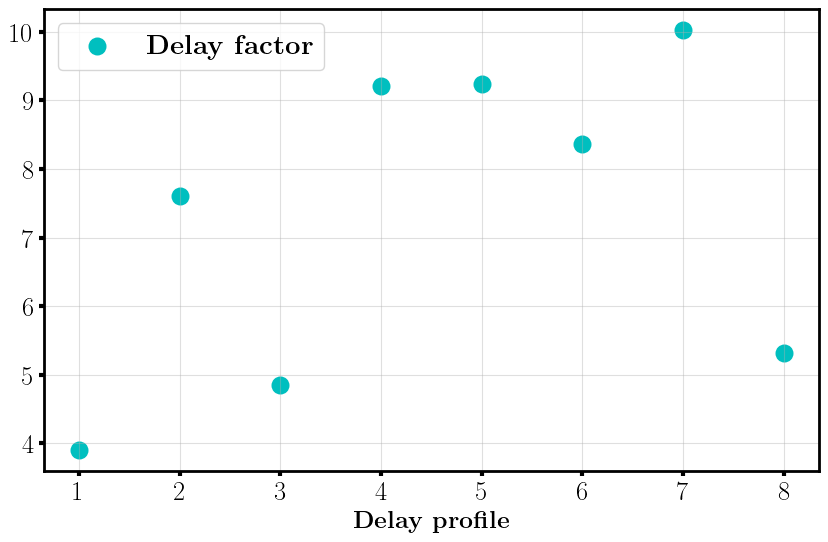

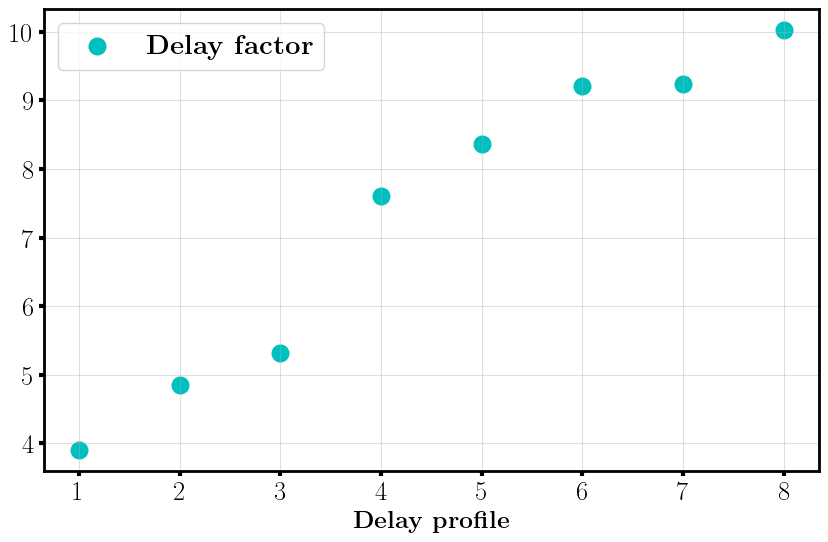

delay profile 1
[0, 0, 0, 0, 100000.0, 0, 0, 0, 0, 0, 0]


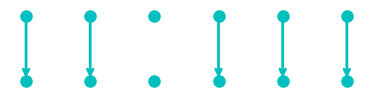

delay profile 2
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


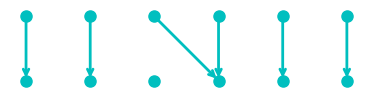

delay profile 3
[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]


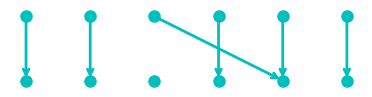

delay profile 4
[0, 0, 0, 100000.0, 100000.0, 0, 0, 0, 0, 0, 0]


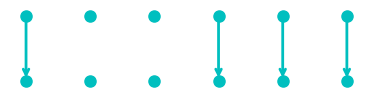

delay profile 5
[0, 0, 0, 10000000.0, 1, 0, 0, 0, 0, 0, 0]


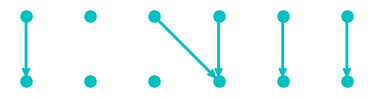

delay profile 6
[0, 0, 0, 2, 1000000.0, 0, 0, 0, 0, 0, 0]


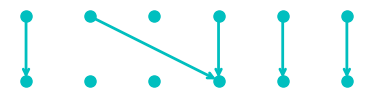

delay profile 7
[0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0]


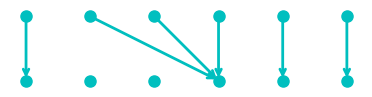

delay profile 8
[0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0]


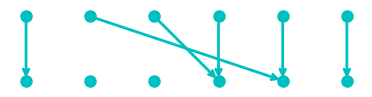

In [7]:
delay_profiles_connections =[[(0, 0), (1, 1), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (1, 1), (2, 3), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (1, 3), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (1, 3), (2, 3), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (2, 3), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (1, 4), (2, 3), (3, 3), (4, 4), (5, 5)],
                             [(0, 0), (1, 1), (2, 4), (3, 3), (4, 4), (5, 5)]
                             ]

delay_profiles = [
                  [0,0,0,0,1e5,0,0,0,0,0,0],
                  [0,0,0,1e5,1e5,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,2,1e6,0,0,0,0,0,0],
                  [0,0,0,2,1,0,0,0,0,0,0],
                  [0,0,0,1e7,1,0,0,0,0,0,0],
                  [0,0,0,3,1,0,0,0,0,0,0,0],
                  [0,0,0,0,2,0,0,0,0,0,0,0],
                  ]


z_p     = 0.9
min_K   = 0
m_min   = -5
m_max   = 15


kapaa_list, t1_list, t2_list, t3_list   = compute_kappa_and_terms_max(delay_profiles, min_K, z_p, m_min, m_max, show=False )
sorted_indicies_kappa                   = plot_sorted(kapaa_list, show=False)
reordered_delay_profiles_connections    = [delay_profiles_connections[i] for i in sorted_indicies_kappa]
reordered_delay_profiles                = [delay_profiles[i] for i in sorted_indicies_kappa]
kappa_final, _, _, _                    = compute_kappa_and_terms_max(reordered_delay_profiles, min_K, z_p, m_min, m_max , show=True)


for connections, delays, i in zip(reordered_delay_profiles_connections, reordered_delay_profiles, np.arange(len(delay_profiles_connections))):
    print(f'delay profile {i+1}')
    print(delays)
    plot_profile(6,connections,i+1,z_p)

## delay factor on real delay matrix and real environment 


In [ ]:
#### no need to sum over all links, they behave approximately the same, the maximum has a mean and variance and we should consider the mean by the law of large numbers.

num_runs    = 100
z_p         = 0.95
min_K       = 2000
max_K       = 2300
m_min       = 1950
m_max       = 2350
u = 0 
v = 1 


delay_types   = ['uniform:1-20','uniform:1-40', 'uniform:1-60', 'uniform_1-40_with_ideal', 'uniform_1-40_with_loss']
results_delay = []

for d_type in delay_types:
    results = np.zeros((num_runs,m_max-m_min))
    print(d_type)
    for run in tqdm(range(num_runs)):
        seed = np.random.randint(1000000)
        num_nodes = 4
        max_iters = 20000

        if d_type == 'uniform_1-40_with_ideal':
            Delay_mat = compute_delay_matrix(seed, num_nodes, max_iters, delay_type='uniform:1-40')
            flat_matrix = Delay_mat.flatten()
            num_zeros = int(flat_matrix.size * 0.5)
            random_indices = np.random.choice(flat_matrix.size, num_zeros, replace=False)
            flat_matrix[random_indices] = 0
            Delay_mat = flat_matrix.reshape(Delay_mat.shape)        
        elif d_type == 'uniform_1-40_with_loss':
            Delay_mat = compute_delay_matrix(seed, num_nodes, max_iters, delay_type='uniform:1-40')
            flat_matrix = Delay_mat.flatten()
            num_zeros = int(flat_matrix.size * 0.5)
            random_indices = np.random.choice(flat_matrix.size, num_zeros, replace=False)
            flat_matrix[random_indices] = 1e7
            Delay_mat = flat_matrix.reshape(Delay_mat.shape)   
        else:
            Delay_mat = compute_delay_matrix(seed, num_nodes, max_iters, delay_type=d_type)

        kappa, m_range, _, _, _ = tau_vu_p_m(Delay_mat,v,u,min_K,max_K, z_p, m_min, m_max)
        results[run,:] = cp.deepcopy(kappa)
    results_delay.append(results)

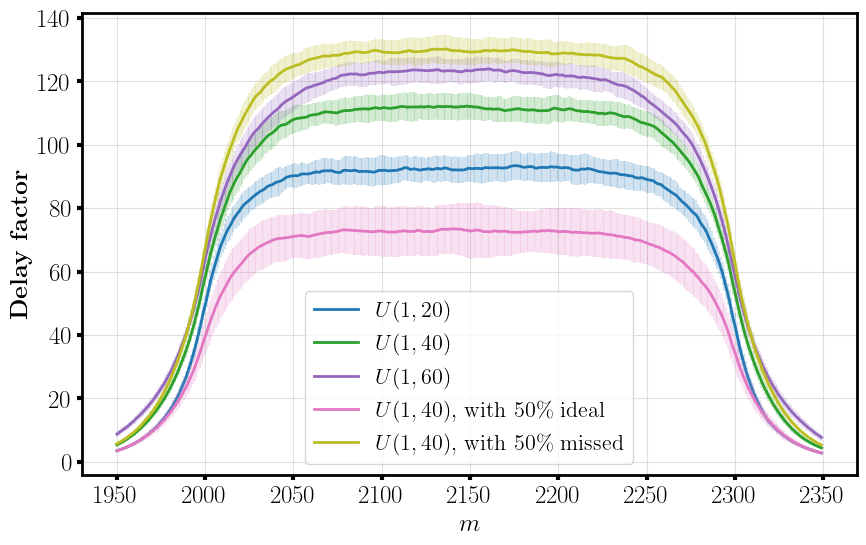

In [ ]:
matplotlib.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "Arial"
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['pdf.fonttype'] = 42
font = FontProperties()
font.set_size(17)
font2 = FontProperties()
font2.set_size(17)
mark_every = 50000
linewidth = 2
folder   = 'check_thm_real_profiles_avg50' 

if not os.path.exists(folder):
    os.makedirs(folder)

colors = plt.cm.tab20(np.linspace(0, 1, len(delay_types)+1))

legend_list = []
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.tick_params(labelsize=18, width=3)
for iii in range(len(delay_types)):
    mean_values = np.mean(results_delay[iii], axis=0)
    std_dev_values = np.std(results_delay[iii], axis=0)
    legend_list.append(delay_types[iii])

    plt.errorbar(m_range, mean_values, yerr=std_dev_values, fmt='none', ecolor=colors[iii], alpha=0.2)
    plt.plot(m_range, mean_values, color=colors[iii], linewidth=2)
# plt.legend(legend_list)
plt.legend(['$U(1,20)$', '$U(1,40)$', '$U(1,60)$', r'$U(1,40)$, with 50\% ideal', r' $U(1,40)$, with 50\% missed'], prop={'size': 16})
plt.grid(True, alpha=0.4)
# plt.legend([r'\textbf{Delay factor}'],  prop={'size': 20})
plt.xlabel(r'$m$', fontsize = 18)
plt.ylabel(r'\textbf{Delay factor}', fontsize = 18)
path = os.path.join(folder, 'kappa_new2')
plt.savefig( path + ".pdf", format = 'pdf', bbox_inches='tight')
plt.show()

### now run the asy-dagp for those profile for several times and compute average. 

In [17]:
def Asy_DAGP_init(seed, prd, num_nodes, dim, max_iter, min_delay, max_delay, neighbors, expScale_delay, delay_type, cons=False, drop_msg=False, drop_prob=0.001):
    z = np.random.randn(num_nodes,dim) 
    if cons:
        x = prd.network_projection(z) 
    else:
        x = cp.deepcopy(z)

    Message=[[[] for a in range(num_nodes)] for aa in range(num_nodes)]

    f_grad = prd.networkgrad(x)
    g = np.zeros(f_grad.shape)
    h = np.zeros(g.shape)
    p = np.zeros(g.shape)

    # print(delay_type)
    np.random.seed(seed)
    if delay_type == 'uniform:1-100':
        Delay_mat = np.random.uniform(1, 100, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-50':
        Delay_mat = np.random.uniform(1, 50, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-60':
        Delay_mat = np.random.uniform(1, 60, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform_1-40_with_ideal':
        Delay_mat = np.random.uniform(1, 40, size=(num_nodes,num_nodes,max_iter+2))
        flat_matrix = Delay_mat.flatten()
        num_zeros = int(flat_matrix.size // 2)
        random_indices = np.random.choice(flat_matrix.size, num_zeros, replace=False)
        flat_matrix[random_indices] = 0
        Delay_mat = flat_matrix.reshape(Delay_mat.shape)        
    elif delay_type == 'uniform_1-40_with_loss':
        Delay_mat = np.random.uniform(1, 40, size=(num_nodes,num_nodes,max_iter+2))
        flat_matrix = Delay_mat.flatten()
        num_zeros = flat_matrix.size // 2
        random_indices = np.random.choice(flat_matrix.size, num_zeros, replace=False)
        flat_matrix[random_indices] = 1e7
        Delay_mat = flat_matrix.reshape(Delay_mat.shape)   
    elif delay_type == 'uniform:1-80':
        Delay_mat = np.random.uniform(1, 80, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-1':
        Delay_mat = np.random.uniform(1, 1, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-2':
        Delay_mat = np.random.uniform(1, 2, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-3':
        Delay_mat = np.random.uniform(1, 3, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-4':
        Delay_mat = np.random.uniform(1, 4, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-20':
        Delay_mat = np.random.uniform(1, 20, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-30':
        Delay_mat = np.random.uniform(1, 30, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-40':
        Delay_mat = np.random.uniform(1, 40, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-5':
        Delay_mat = np.random.uniform(1, 5, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-10':
        Delay_mat = np.random.uniform(1, 10, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-500':
        Delay_mat = np.random.uniform(1, 500, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-1000':
        Delay_mat = np.random.uniform(1, 1000, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'uniform:1-50':
        Delay_mat = np.random.uniform(1, 50, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'exp:scale:10':
        Delay_mat = np.random.exponential(10,   size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'no_delay':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'one_node_constant_delay_500':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        Delay_mat[:,0,:] = np.random.uniform(500,500,(num_nodes, max_iter+2))
    elif delay_type == 'all_nodes_constant_delay_100':
        Delay_mat = np.random.uniform(100, 100, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'all_nodes_constant_delay_500':
        Delay_mat = np.random.uniform(500, 500, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'all_nodes_constant_delay_1000':
        Delay_mat = np.random.uniform(1000, 1000, size=(num_nodes,num_nodes,max_iter+2))
    elif delay_type == 'counter_example_one_node_fails': ## all messages are lost
        Delay_mat = np.random.uniform(min_delay, max_delay, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[:,0,:] = np.random.normal(1e10, 0, (num_nodes, max_iter+2))
    elif delay_type == '20percent_1_link_delay_10_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2)) 
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(10,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_20_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2)) 
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(20,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_40_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2)) 
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(40,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_80_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(80,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_160_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(160,0,(num_nodes,len(rand_iters)))
    elif delay_type == '20percent_1_link_delay_400_others_ideal':
        Delay_mat = np.zeros((num_nodes,num_nodes,max_iter+2))
        np.random.seed(seed)
        rand_iters = np.random.randint(1, max_iter, size=int(max_iter/5))
        Delay_mat[:,0, rand_iters] = np.random.normal(400,0,(num_nodes,len(rand_iters)))
    elif delay_type == 'normal_150_10':
        Delay_mat = np.random.normal(150,10, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_20':
        Delay_mat = np.random.normal(150,20, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_40':
        Delay_mat = np.random.normal(150,40, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_80':
        Delay_mat = np.random.normal(150,80, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_600_80':
        Delay_mat = np.random.normal(600,80, size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_150_0':
        Delay_mat = np.random.normal(150,0,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_10_1':
        Delay_mat = np.random.normal(10,1,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_10_5':
        Delay_mat = np.random.normal(10,5,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    elif delay_type == 'normal_10_20':
        Delay_mat = np.random.normal(10,20,  size=(num_nodes,num_nodes,max_iter+2))
        Delay_mat[Delay_mat < 0] = 0
    for i in range(max_iter):
        np.fill_diagonal(Delay_mat[:,:,i], 0)

    active_set= []

    A = np.zeros((num_nodes,num_nodes,dim))
    for node in range(num_nodes):
        A[node,node,:] = x[node,:]
    B = np.zeros((num_nodes,num_nodes,dim))

    for node in range(num_nodes):
        Message, _ = broadcast_dagp(node, x, p, current=0, Delay_mat=Delay_mat, Message=Message, itr=0, dropping_msg=drop_msg, dropping_prob=drop_prob, neighbors=neighbors)

    x_out = [cp.deepcopy(x)]
    z_out = [cp.deepcopy(z)]
    g_out = [cp.deepcopy(g)]
    h_out = [cp.deepcopy(h)]
    p_out = [cp.deepcopy(p)]

    return x, z,  Message, Delay_mat, f_grad, g, h, p, A, B, active_set, x_out, z_out, g_out, h_out, p_out


def Asy_DAGP(seed, T_active, Tv_nodes, prd, R, C, learning_rate, max_iter, num_nodes, dim, rho, alpha, alpha_vr, eta, neighbors, \
        cons = False, delay_type='uniform', min_delay=0, max_delay=10, expScale_delay=10, drop_msg=False, drop_prob=0.001):

    x, z, Message, Delay_mat, f_grad, g, h, p, A, B, active_set, x_out, z_out, g_out, h_out, p_out = Asy_DAGP_init(seed, prd, num_nodes, dim, \
            max_iter=max_iter, min_delay=min_delay, max_delay=max_delay, neighbors=neighbors, expScale_delay=expScale_delay,\
                  delay_type=delay_type, cons=cons, drop_msg=drop_msg, drop_prob=drop_prob)

    drop_counter = 0
    itr = 0
    for t_active in T_active[1:max_iter]:
        itr += 1
        active_set.append(ut.active_set(t_active, Tv_nodes))
        
        for node in active_set[-1]:
            z, x, g, p, h, f_grad = update_variables_dagp(node,prd,z,x,g,p,h,f_grad,R,learning_rate,alpha,eta,alpha_vr,rho,C,A,B,cons)
            
        for node in active_set[-1]:
            Message, tmp_counter  = broadcast_dagp(node, x, p, t_active, Delay_mat, Message, itr, dropping_msg=drop_msg, dropping_prob=drop_prob, neighbors=neighbors)
            drop_counter += tmp_counter

        for node in active_set[-1]:
            Message, A, B = update_estimates_dagp(node, Message, A, B, dim, t_active, neighbors)
            
        x_out, z_out, g_out, h_out, p_out = save_vars_dagp(x,z,g,h,p, x_out, z_out, g_out, h_out, p_out)
        # ut.monitor('ASY-DAGP',itr,max_iter)
    if drop_msg:
        print(f'number of dropped messages: {drop_counter}')

    return x_out, z_out, g_out, h_out, p_out, Delay_mat


In [ ]:
seed         = np.random.randint(12345)  
np.random.seed(seed)

num_nodes    = 4
dim          = 8
mincomp      = np.array([1,1,1,1,1,1,1,1,1,1])
maxcomp      = np.array([1,1,1,1,1,1,1,1,1,1])

T_active_exp1, Tv_nodes_exp1, node_comp_time_exp1 = \
    ut.create_computation_time(num_nodes, max_iter=int(1e5), comp_time_dist='random_uniform' , mean_comp=None,\
                                      min_comp = mincomp, max_comp=maxcomp, variance_comp=None, make_integer=True) 

                                   
learning_rate     = 0.01
max_iter_asyn     = 6000

rho               = 0.01         
alpha             = 0.1
gamma             = 0.5
eta               = 1.0

graph_prob        = 1.0
drop_prob         = 0.0


prd = synthetic(seed, num_nodes, dim)
error_prd = error(prd,np.zeros(num_nodes),0)

zero_row_sum,zero_column_sum,row_stochastic,col_stochastic,N_out,neighbors = Random(num_nodes, prob=graph_prob, Laplacian_dividing_factor= 2).directed()

expScale = 1/10.

delay_types   = ['uniform:1-20','uniform:1-40', 'uniform:1-60', 'uniform_1-40_with_ideal', 'uniform_1-40_with_loss' ]

num_runs = 10

x_asy_dagp_list = []
f_asy_dagp_list = []

for delay_type in delay_types:
    print(delay_type)
    results2 = np.zeros((num_runs,max_iter_asyn))
    for run in tqdm(range(num_runs)):
        seed = np.random.randint(1000000)
        x_asy_dagp, z_asy_dagp, g_asy_dagp, h_asy_dagp, p_asy_dagp, Delay_mat_dagp = \
            Asy_DAGP(seed, T_active_exp1, Tv_nodes_exp1,  prd, zero_row_sum, zero_column_sum, learning_rate, max_iter_asyn, num_nodes, dim, rho, alpha, gamma, eta, neighbors, \
                    cons = False, delay_type=delay_type, min_delay=None, max_delay=None, expScale_delay=expScale, \
                        drop_msg=False, drop_prob=drop_prob)
        f_asy_dagp = error_prd.cost_path(np.sum(x_asy_dagp,  axis=1)/num_nodes) 
        results2[run,:] = cp.deepcopy(f_asy_dagp)
    f_asy_dagp_list.append(results2)

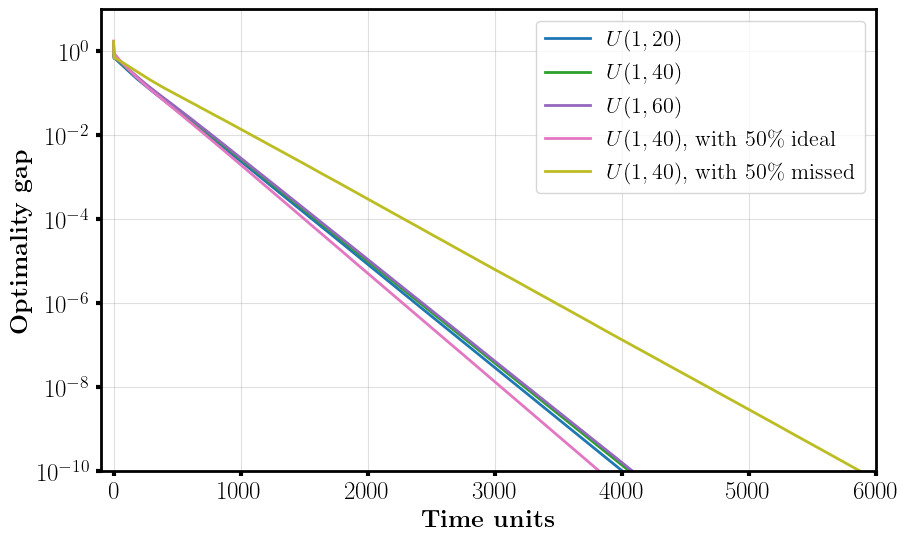

: 

In [ ]:

if not os.path.exists(folder):
    os.makedirs(folder)

### find the optimal solution
x_dagp, _, _, _  = dopt.DAGP(prd, zero_row_sum, zero_column_sum, 0.01, 120000, np.random.randn(num_nodes,dim), rho , alpha, cons = False)

f_dagp = error_prd.cost_path(np.sum(x_dagp,  axis=1)/num_nodes) 
f_opt  = f_dagp[-1]

colors = plt.cm.tab20(np.linspace(0, 1, len(delay_types)+1))
delay_types   = ['uniform:1-20','uniform:1-40', 'uniform:1-60', 'uniform_1-40_with_ideal', 'uniform_1-40_with_loss' ]


%matplotlib inline
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 6))
legend_list =[]
plt.grid(True, alpha=0.4)
plt.yscale('log')

plt.tick_params(labelsize=18, width=3)


for iii in range(len(delay_types)):
    mean_values = np.mean(f_asy_dagp_list[iii], axis=0)
    std_dev_values = np.std(f_asy_dagp_list[iii], axis=0)
    legend_list.append(delay_types[iii])
    plt.plot(np.arange(max_iter_asyn), mean_values-f_opt, color=colors[iii], linewidth=2)

plt.xlim(-100,6000)
plt.ylim(1e-10,1e1)
plt.legend(['$U(1,20)$', '$U(1,40)$', '$U(1,60)$', r'$U(1,40)$, with 50\% ideal', r' $U(1,40)$, with 50\% missed'], prop={'size': 16})
plt.xlabel(r'\textbf{{Time units}}', fontsize = 18)
plt.ylabel(r'\textbf{{Optimality gap}}', fontsize = 18)
path = os.path.join(folder, 'objective_delay_type_new2')


# plt.xlim(3200, 4200)
# plt.ylim(1e-10, 1e-8)
# plt.title(r'\textbf{zoomed in}', fontsize = 18)
# plt.tick_params(labelsize=22, width=3)
# path = os.path.join(folder, 'objective_delay_type_zoom_new2')


plt.savefig( path + ".pdf", format = 'pdf', bbox_inches='tight')
plt.show()